In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

In [2]:
def check_jpg_counts(path):
    cnt = 0
    for dir_name in os.listdir(path):
        dir_path = os.path.join(path, dir_name)
        if os.path.isdir(dir_path):
            jpg_count = sum(1 for f in os.listdir(dir_path) if f.endswith(".jpg"))
            if jpg_count != 170:
                print(f"file {dir_name} has {jpg_count} number .jpg")
            cnt += jpg_count
    print('other files each 170 number .jpg')
    print(f"total {cnt} number .jpg")


_dataset_dir = "./data/PIE"
check_jpg_counts(_dataset_dir)

file 69 has 10 number .jpg
file 38 has 164 number .jpg
other files each 170 number .jpg
total 11564 number .jpg


In [3]:
test_tfm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # change own image to 1 channel
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


class FaceDataset(Dataset):

    def __init__(self, path, tfm=test_tfm, files=None):
        super(FaceDataset, self).__init__()
        self.path = path
        self.files = self._get_all_files(path) if files is None else files
        if len(self.files) == 0:
            raise ValueError(f"No .jpg files found in {path}")
        print(f"One {path} sample", self.files[0])
        self.transform = tfm

    def _get_all_files(self, path):
        """Recursively get all jpg files."""
        file_list = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg'):
                    file_list.append(os.path.join(root, file))
        return sorted(file_list)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        im = Image.open(fname)
        if self.transform:
            im = self.transform(im)
        try:
            label = int(fname.split("/")[-2])  # adjusted to get the parent directory as label
        except:
            label = -1  # test has no label
        return im, label



In [4]:
# Assuming test_tfm is defined elsewhere
_dataset_dir = "./data"
data_set = FaceDataset(os.path.join(_dataset_dir, "PIE"))
N = len(data_set)
train_size = int(0.8 * N)
test_size = N - train_size
ratio = 0.8
train_set, test_set = random_split(data_set, [train_size, test_size])
print(N)
print(len(train_set), len(test_set))

One ./data/PIE sample ./data/PIE/1/1.jpg
11564
9251 2313


One ./data/own sample ./data/own/69/1.jpg
10
8 2


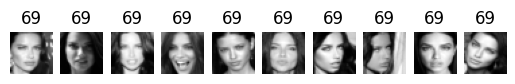

In [5]:
def imshow(tensor_image):
    # 将张量转换为numpy数组
    image = tensor_image.numpy().squeeze()  # 删除大小为1的维度

    plt.imshow(image, cmap='gray')  # 使用灰度色图
    # 如果是归一化的图像, 可能需要取消归一化
    # mean = np.array([0.5, 0.5, 0.5])
    # std = np.array([0.5, 0.5, 0.5])
    # image = std * image + mean
    # image = np.clip(image, 0, 1)  # 确保图像值位于0到1之间

    plt.imshow(image)
    plt.axis('off')
    plt.show()


_dataset_dir = "./data"
own_data_set = FaceDataset(os.path.join(_dataset_dir, "own"))
N = len(own_data_set)
own_train_size = int(0.8 * N)
own_test_size = N - own_train_size
own_train_set, own_test_set = random_split(own_data_set, [own_train_size, own_test_size])
print(N)
print(len(own_train_set), len(own_test_set))
for i in range(0, 10):
    plt.subplot(1, 10, i + 1)
    image = own_data_set[i][0].numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.title(own_data_set[i][1])
    plt.axis('off')

plt.show()

In [6]:
num_samples = 500
train_loader = DataLoader(train_set, batch_size=num_samples, shuffle=True)
test_loader = DataLoader(test_set, batch_size=num_samples // 5, shuffle=True)
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))

In [7]:
class PCA:
    def __init__(self):
        pass

    def fit(self, X, n_components):
        X = X.reshape(-1, 32 * 32)
        mean_X = X.mean(axis=0)
        centered_X = X - mean_X

        u, s, vh = np.linalg.svd(centered_X, full_matrices=False)
        s_matrix = np.diag(s)

        # max components: 200
        X_pca = u[:, :n_components] @ s_matrix[:n_components, :n_components]

        return u, s, vh, X_pca

In [8]:
pca = PCA()

In [9]:
u, s, vh, X_pca = pca.fit(x_train, 200)

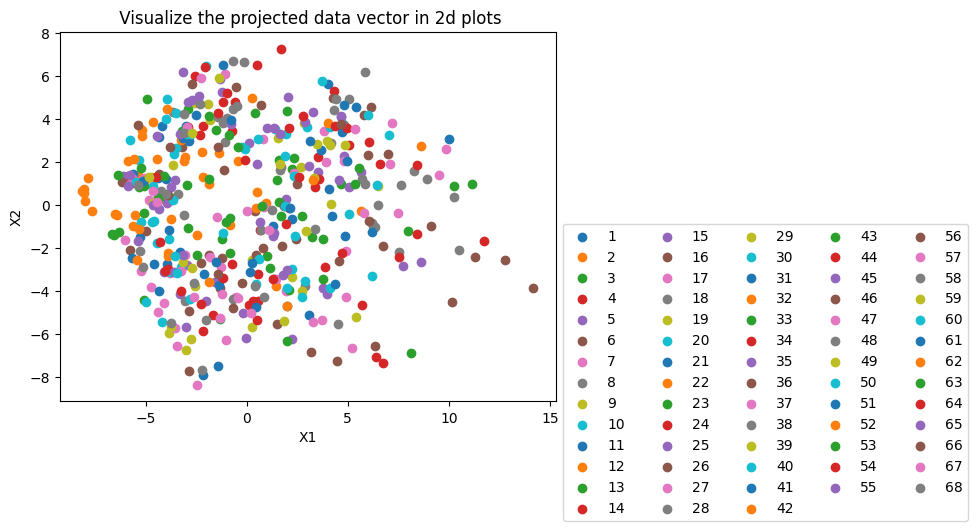

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
for i in np.unique(y_train):
    ax.scatter(X_pca[y_train == i][:, 0], X_pca[y_train == i][:, 1], label=i)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
lgd = ax.legend(ncol=np.int_(25 / 5), bbox_to_anchor=(1, 0.5))
ax.set_title(' Visualize the projected data vector in 2d plots')
plt.show()

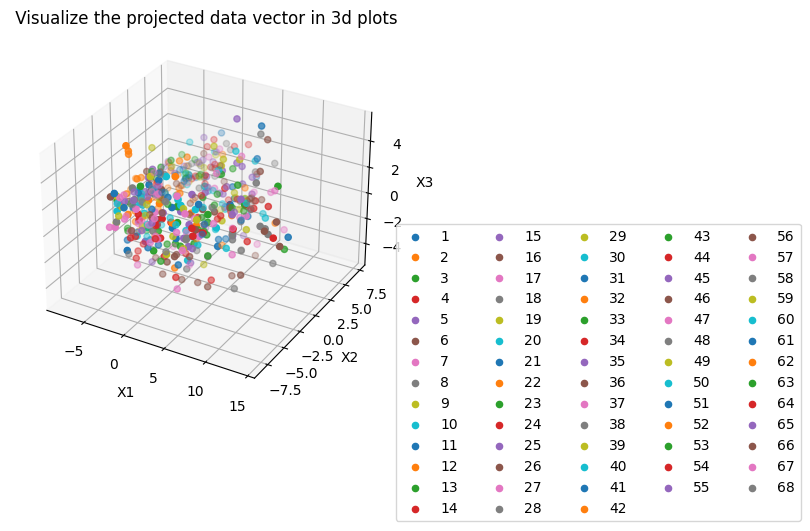

In [11]:
# 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for i in np.unique(y_train):
    ax.scatter(X_pca[y_train == i][:, 0], X_pca[y_train == i][:, 1], X_pca[y_train == i][:, 2], label=i, )

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")

lgd = ax.legend(ncol=np.int_(25 / 5), bbox_to_anchor=(1, 0.5))
ax.set_title(' Visualize the projected data vector in 3d plots')
plt.show()

(-0.5, 31.5, 31.5, -0.5)

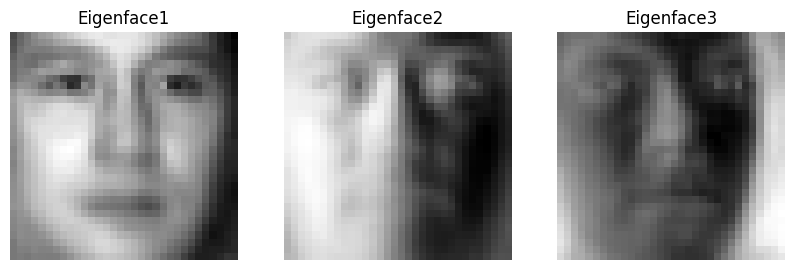

In [12]:
def ComputeEigenface(eigenface):
    normalized = (
            (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface)) * 255
    )
    return Image.fromarray(normalized.astype("uint8").reshape(32, 32), "L")


#===========================================
face_1 = ComputeEigenface(vh[0])
face_2 = ComputeEigenface(vh[1])
face_3 = ComputeEigenface(vh[2])
# plot
plt.figure(figsize=(10, 8))
plt.subplot(1, 3, 1)
plt.imshow(face_1, cmap='gray')
plt.title('Eigenface' + str(1))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(face_2, cmap='gray')
plt.title('Eigenface' + str(2))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(face_3, cmap='gray')
plt.title('Eigenface' + str(3))
plt.axis('off')

In [34]:
x_test = []
y_test = []
for X, y in test_loader:
    x_test = X.reshape(-1, 32 * 32).numpy()
    y_test = y
    break
# Center test set (PIE)
mean_X_test = x_test.mean(axis=0)
centered_X_test = x_test - mean_X_test

own_test_loader = DataLoader(own_test_set, batch_size=len(own_data_set) // 5, shuffle=True)
own_x_test, own_y_test = [], []
for X, y in own_test_loader:
    own_x_test = X.reshape(-1, 32 * 32).numpy()
    own_y_test = y
    break
# Center test set (own)
own_mean_X_test = own_x_test.mean(axis=0)
own_centered_X_test = own_x_test - own_mean_X_test

# PCA projection
X_pca_test = centered_X_test @ vh.T[:, :200]
own_X_pca_test = own_centered_X_test @ vh.T[:, :200]

In [36]:
def NN_classification(dim, X, y):
    dist_arr_test = np.linalg.norm(X[:, :dim][:, np.newaxis] - X_pca[:, :dim], axis=2)
    dist_arr_test = np.argsort(dist_arr_test)  # get the indices (cols) in sorted order

    k = 1  # Unique person
    # Get knn indices then use them to access label
    knn_indices = dist_arr_test[:, :k]
    knn_indices.squeeze()

    knn_labels = y_train[knn_indices[:, 0]]
    # knn_labels = []
    # for i in range(len(knn_indices)):
    #     knn_labels.append(y_train[knn_indices[i][0]])
    knn_labels = np.array(knn_labels)
    
    # Original rows (X values we want to check) are preserved, so we apply
    # KNN formula to each row, but ignore k since its constant here
    result = knn_labels[:]
    # print(result)
    # print(y)
    result = torch.tensor([result])
    matches = (result == y).float()
    acc = torch.sum(matches) / y.size(0)
    # print(y.size(0))
    return acc


def Accuracy(X, y):
    for i in [40, 80, 200]:
        print(
            "Accuracy with dim",
            i,
            "=",
            NN_classification(i, X, y),
        )


#===================================================
print("For PIE:")
Accuracy(X_pca_test, y_test)
print("For own photos:")
Accuracy(own_X_pca_test, own_y_test)

For PIE:
100
Accuracy with dim 40 = tensor(0.2400)
100
Accuracy with dim 80 = tensor(0.2800)
100
Accuracy with dim 200 = tensor(0.3100)
For own photos:
2
Accuracy with dim 40 = tensor(0.)
2
Accuracy with dim 80 = tensor(0.)
2
Accuracy with dim 200 = tensor(0.)


# own dataset is too small, which can not influence the distribution of the training set